In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
plt.style.use('fivethirtyeight')

In [2]:
pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 50)  # or 1000
pd.set_option('display.max_colwidth', 50)  # or 199

In [34]:
p = Path('./the_movie_dataset')
p

PosixPath('the_movie_dataset')

In [35]:
path = Path('./the_movie_dataset')
files = [p for p in path.glob('*.csv')]
files

[PosixPath('the_movie_dataset/links_small.csv'),
 PosixPath('the_movie_dataset/links.csv'),
 PosixPath('the_movie_dataset/credits.csv'),
 PosixPath('the_movie_dataset/date.csv'),
 PosixPath('the_movie_dataset/movies_metadata.csv'),
 PosixPath('the_movie_dataset/info_budget_1.csv'),
 PosixPath('the_movie_dataset/ratings.csv'),
 PosixPath('the_movie_dataset/info_budget_3.csv'),
 PosixPath('the_movie_dataset/info_budget_2.csv'),
 PosixPath('the_movie_dataset/ratings_small.csv'),
 PosixPath('the_movie_dataset/keywords.csv')]

# # About Data Sets
### - 데이터 출처
- kaggle : [The movies data set](https://www.kaggle.com/rounakbanik/the-movies-dataset)
    - Metadata on over 45,000 movies. 26 million ratings from over 270,000 users.
- MovieLens: [GroupLens Movie data set](https://grouplens.org/datasets/movielens/)
    - 최신의 rating data와 user의 수가 더 많기 때문에 rating 정보는 movie len 데이터를 사용하였음.
- Awards by Directors : [220k_awards_by_directors](https://www.kaggle.com/stephanerappeneau/350-000-movies-from-themoviedborg)
    - tmdb api를 기본으로 감독의 수상 & 노미네이트 정보를 담고 있음
- Web Crawling
    1) tmdb api에서 budset, gross 정보가 누락된 영화들의 imdb page를 crawling 하였음
    2) 주연배우 3명까지 배우들의 Wiki page crawling 해서 각종 수상 & 노미네이트 횟수를 Count 하였음
---
# 0.  Meta_data
#### the movies data set의 meta data는 기본적으로 tmdb api에서 긁어온 정보들로 구성되어 있기 때문에 전처리가 많이 필요함.

#### Meta data 기본적인 클리닝
- id : links의 tmdbID를 의미한다.
- imdb_id : links의 imdbid와 일치 하지만 tt를 제거 해야한다.
- 기본적인 클리닝 수행함
    - imdb_id 수정
    - imdb_id 결측 제거(link와 일치 시킬 수가 없음)
    - 배급, 나라 정보 없는 영화 데이터는 이상한 값이 들어가 있음(3개) - 제거
    - original_language 정보 없는 11개 컬럼 spoken_languagers에서 1번 언어로 뽑아서 채워줌
    - 필요없는 컬럼 제거(홈페이지, 포스터 경로, tagline)

In [36]:
meta_data = pd.read_csv([f for f in files if 'metadata' in str(f)][0])

def cleaning_meta_data(df):
    
    df = df.copy()
    # 컬럼 이름 id = tmdbId
    df.rename({'id':'tmdbID'}, axis=1, inplace=True)
    
    # imdb_id 결측 17개 제거(어차피 못찾음)
    df = df.loc[~df['imdb_id'].isnull()]
    # 컬럼 imdb_id -> tt 제거하고 컬럼이름 imdbId로 link file과 index로 사용
    df['imdbId'] = df['imdb_id'].str.replace('tt','')
    
    # 배급, 나라 정보 없는 영화 3개인데  모든 정보가 없음
    df = df.loc[~df['production_companies'].isnull()]
    # spoken 결측 3개도 이상한 값으로 들어가 있음 제거
    df = df.loc[~df['spoken_languages'].isnull()]
    
    # original_language 정보 없는 11개 컬럼 spoken_languagers에서 1번 언어로 뽑아서 채워줌
    list_up = df[df['original_language'].isnull()].index
    for n,i in enumerate(df.loc[df['original_language'].isnull(),'spoken_languages']):
        cast = eval(i)
        lang = cast[0]['iso_639_1']
        df.loc[list_up[n],'original_language'] = lang
    
    # 필요없는 컬럼 제거 
    # tagline은 다른 정보로 대체 해야함, 결측이 너무 많음(절반이 결측)
    # revenue, budget은 크롤링 데이터로 대체
    cols = ['homepage','poster_path','tagline','imdb_id'
#             ,'adults'
#             ,'revenue'
#             ,'budget'
           ]
    df = df.drop(columns=cols)
    
    return df

meta_data = cleaning_meta_data(meta_data)

/Users/gray/Desktop/ai_local/.conda-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [37]:
meta_data.isnull().sum()

adult                        0
belongs_to_collection    40955
budget                       0
genres                       0
tmdbID                       0
original_language            0
original_title               0
overview                   952
popularity                   0
production_companies         0
production_countries         0
release_date                81
revenue                      0
runtime                    255
spoken_languages             0
status                      81
title                        0
video                        0
vote_average                 0
vote_count                   0
imdbId                       0
dtype: int64

In [38]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45443 entries, 0 to 45465
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45443 non-null  object 
 1   belongs_to_collection  4488 non-null   object 
 2   budget                 45443 non-null  object 
 3   genres                 45443 non-null  object 
 4   tmdbID                 45443 non-null  object 
 5   original_language      45443 non-null  object 
 6   original_title         45443 non-null  object 
 7   overview               44491 non-null  object 
 8   popularity             45443 non-null  object 
 9   production_companies   45443 non-null  object 
 10  production_countries   45443 non-null  object 
 11  release_date           45362 non-null  object 
 12  revenue                45443 non-null  float64
 13  runtime                45188 non-null  float64
 14  spoken_languages       45443 non-null  object 
 15  st

# 1. Movie Meta Date Cleaning & Feature engineering
## Step 1) Meta 데이터 클리닝
- api에서 json형태로 받은 데이터를 그대로 넣어주었기 때문에, 결측 데이터가 null값 대신 텍스트형태로 '[]'가 들어가 있음 
- 결측 데이터 수 확인

In [39]:
print(f'{meta_data.shape}')
print('장르 정보가 없는 영화 수 : ',len([g for g in meta_data['genres'] if len(g) < 10]))
print('배급사 정보가 없는 영화 수 : ',len([g for g in meta_data['production_companies'] if len(g) < 10]))
print('제작한 나라 정보가 없는 영화 수 : ',len([g for g in meta_data['production_countries'] if len(g) < 10]))
print('언어 정보가 없는 영화 수 : ',len([g for g in meta_data['spoken_languages'] if len(g) < 10]))
print('매출 정보가 없는 영화 수 : ',len([f for f in meta_data['revenue'] if f<1]))
print('예산 정보가 없는 영화 수 : ',len([f for f in meta_data['budget'] if int(f)<1]))

(45443, 21)
장르 정보가 없는 영화 수 :  2437
배급사 정보가 없는 영화 수 :  11865
제작한 나라 정보가 없는 영화 수 :  6274
언어 정보가 없는 영화 수 :  3822
매출 정보가 없는 영화 수 :  38035
예산 정보가 없는 영화 수 :  36555


### 1) adult & video
- adult, video는 범주 비율을 볼때, 정보가 없음 drop

In [40]:
print(meta_data['adult'].value_counts(dropna=False))
print(meta_data['video'].value_counts(dropna=False))

False    45434
True         9
Name: adult, dtype: int64
False    45350
True        93
Name: video, dtype: int64


### 2-1) original language
- original_language, 카디널리티 89,  거의 대부분의 비율이 english, 10작품 미만의 언어가 절반.  
- 전략 : 10작품 이하의 언어를 제 3세계 언어로 통합해주었음

10 작품 미만의 언어 수 : 41
5 작품 미만의 언어 수 : 32


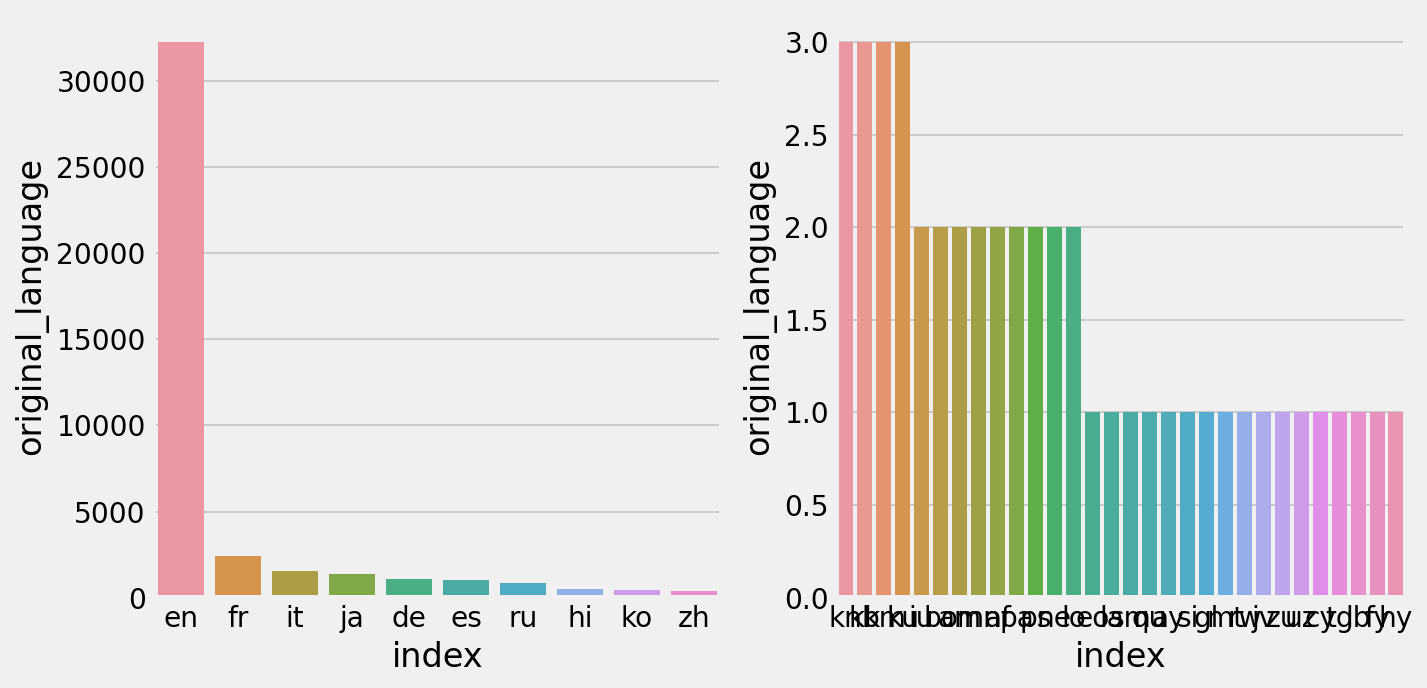

In [41]:
df_plt = meta_data['original_language'].value_counts(dropna=False).reset_index()
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.barplot(data = df_plt
            ,x = df_plt['index'][:10], y=df_plt['original_language'][:10], ax=ax[0])
sns.barplot(data = df_plt
            ,x = df_plt['index'][-30:], y=df_plt['original_language'][-30:], ax=ax[1])
# 89개의 언어중 41개(약 절반)의 언어가 10편 미만
print('10 작품 미만의 언어 수 :',len(df_plt[df_plt['original_language']<10]))
print('5 작품 미만의 언어 수 :',len(df_plt[df_plt['original_language']<5]))

In [42]:
# 10개 이하의 count를 갖는 언어의 list를 뽑고
# 언어를 key로 'etc'를 value로 하는 dictionary를 만듦
min_lang = meta_data['original_language'].value_counts(dropna=False)
min_lang = min_lang[min_lang<11].index.to_list()
min_lang_mapper = {i:'etc' for i in min_lang}

In [318]:
# 잘 들어가나 체크
meta_data['original_language'].map(min_lang_mapper).fillna(meta_data['original_language']).value_counts(dropna=False)

en     32257
fr      2438
it      1529
ja      1348
de      1082
es       994
ru       826
hi       508
ko       444
zh       409
sv       385
pt       316
cn       313
fi       297
nl       248
da       225
pl       217
tr       150
etc      141
cs       131
el       113
no       106
fa       101
hu       100
ta        78
th        76
he        67
sr        63
ro        57
te        45
ar        39
ml        36
xx        35
hr        29
bn        29
mr        25
is        24
et        24
tl        23
id        20
ka        18
lv        18
sl        17
uk        16
bs        14
ca        12
Name: original_language, dtype: int64

In [43]:
# map 함수를 사용해서 mapping 
# 10개 이상 언어들은 mapper에 없기 때문에 nan으로 return됨
# fillna로 original data를 채워줌
meta_data['original_language'] = meta_data['original_language'].map(min_lang_mapper).fillna(meta_data['original_language'])

### 2-2) Spoken languages
- 영화 내에서 사용된 언어 종류  
- 사용된 언어 종류의 count를 특성으로 사용

In [44]:
meta_data['spoken_languages'] = ( meta_data['spoken_languages'].fillna('[]')
                                 .apply(ast.literal_eval)
                                 .apply(lambda x: len(x) if isinstance(x, list) else np.nan) )

### 3) 예산(budget)과 수익(revenue) 관련 처리
> 예산(budget)과 수익(revenue)의 경우 1/4정도만 데이터를 가지고 있음   
> 정보를 추가해 보기 위해 imdb 사이트 크롤링을 수행하였고, 5000건 이상의 데이터를 추가로 얻을 수 있었음  
> 또한, meta data의 budget 데이터의 단위가 통일되지 않은것을 발견하여 쓸 수없다고 판단.  
> 크롤링 데이터를 전처리해서 사용함



In [45]:
# 크롤링 데이터 read
files_budget = [f for f in files if 'info_' in str(f)]

ff = (pd.read_csv(f, index_col=None, header=0) for f in files_budget)
budgets = pd.concat(ff, axis=0, ignore_index=True)
budgets.head()

,imdbId,budget,gross_usa,gross_world
0,tt0114709,"$30,000,000\n(estimated)\n","$223,225,679","$373,554,033"
1,tt0113497,"$65,000,000\n(estimated)\n","$100,499,940","$262,797,249"
2,tt0113228,"$25,000,000\n(estimated)\n","$71,518,503","$71,518,503"
3,tt0114885,"$16,000,000\n(estimated)\n","$67,052,156","$81,452,156"
4,tt0113041,"$30,000,000\n(estimated)\n","$76,594,107","$76,594,107"


In [498]:
# 예산이 달러가 아닌 경우가 꽤 있음
for i in [f for f in budgets['budget'] if ('DEM' in f)]:
    print(budgets[budgets['budget']==i])

        imdbId                        budget   gross_usa gross_world
299  tt0110963  DEM42,000,000\n(estimated)\n  $1,304,237  $1,318,578
        imdbId                       budget gross_usa gross_world
614  tt0102855  DEM6,340,000\n(estimated)\n        []          []
        imdbId                        budget gross_usa gross_world
647  tt0117117  DEM11,500,000\n(estimated)\n        []          []
          imdbId                        budget gross_usa gross_world
746    tt0108211  DEM20,000,000\n(estimated)\n  $152,972    $152,972
14466  tt0052924  DEM20,000,000\n(estimated)\n    $4,673      $4,673
         imdbId                     budget gross_usa gross_world
856   tt0075169  DEM600,000\n(estimated)\n        []          []
9990  tt0075165  DEM600,000\n(estimated)\n    $8,144      $8,144
         imdbId                        budget    gross_usa  gross_world
1205  tt0082096  DEM32,000,000\n(estimated)\n  $11,487,676  $11,487,676
          imdbId                       budget   gr

- 각 나라 단위로 되어 있는 budget을 달러로 통일 하기 위해서 currency mapping
- 현재 시점의 us달러 환율로 변환하지만, 시간점에 따라서 환율이 달랐을 것이기 때문에 정확하지는 않음
- 해당 시점의 환율 정보를 제공하지 않는 경우가 많고, imdb에서 각 년도에 따른 환율을 반영해서 정보를 넣었을 것으로 생각되지는 않음

In [ ]:
# dollor 단위 아닌 화폐 종류 get
not_Dollor = [f for f in budgets['budget'] if ('$' not in f and '[]' not in f)]
kind_of_bills = set([f[:3] for f in not_Dollor])
kind_of_bills 

In [46]:
# kind of bills들의 달러 환율을 하나씩 찾아서 mapping 하였음
currency = {
             'AMD': 0.0019,
             'ARS': 0.011,
             'ATS': 0.088,
             'AUD': 0.79,
             'BEF': 0.12,
             'BGL': (0.6/20),
             'BND': 0.75,
             'BRL': 0.19,
             'CAD': 0.79,
             'CHF': 1.11,
             'CLP': 0.0014,
             'CNY': 0.15,
             'COP': 0.00028,
             'CZK': 0.047,
             'DEM': 0.62,
             'DKK': 0.16,
             'EEK': (0.78/10),
             'EGP': 0.064,
             'ESP': (0.73/100),
             'EUR': 1.21,
             'FIM': (4.08/20),
             'FRF': (3.70/20),
             'GBP': 1.40,
             'HKD': 0.13,
             'HRK': 0.16,
             'HUF': 0.0034,
             'IDR': 0.000071,
             'IEP': 1.54,
             'ILS': 0.31,
             'INR': 0.014,
             'IRR': 0.000024,
             'ISK': 0.0078,
             'ITL': (6.27/10),
             'JMD': 0.0066,
             'JPY': 0.0095,
             'KRW': 0.0009,
             'LTL': 2.89,
             'LVL': (165.32/100),
             'MXN': 0.048,
             'MYR': 0.25,
             'NGN': 0.0024,
             'NLG': 0.54,
             'NOK': 0.12,
             'NZD': 0.73,
             'PHP': 0.021,
             'PKR': 0.0063,
             'PLN': 0.27,
             'PTE': (1.21/200),
             'ROL': 0.25,
             'RUR': 0.013,
             'SEK': 0.12,
             'SGD': 0.75,
             'SIT': (50.66/10000),
             'THB': 0.033,
             'TRL': 0.14,
             'TWD': 0.036,
             'UAH': 0.036,
             'VEB': np.nan,
             'XAU': np.nan,
             'ZAR': 0.067
        }

In [47]:
# 각 나라의 화폐를 달러로 보정해주는 함수
def cleaning_budget(x):
    
    if x =='[]': # 정보 없는 빈칸 -> nan
        return np.nan
    
    budget = x.split('\n')[0].replace('$','').replace(',','')
    
    try :
        # $ , 제거하고 int로 바뀌면 원래 달러로 된 데이터
        budget = int(budget)
        
        if budget == 0: # $0 이렇게 표시된 곳도 있음 -> nan
            budget = np.nan
            
    except : # int로 바꾸지 못하고 errer가 생기면 달러가 아니기 때문에 exception
        
        kind_of_bill = x.split('\n')[0].replace('%','').replace(',','')[:3]
        # 위에서 작성한 currency 에서 화폐종류에 mapping된 환율
        exchange_ = currency.get(kind_of_bill, 1) # 3번째 자리에 화폐단위가 있으면 환율, 없으면 그냥 달러
        # 달러 환율 곱해서 돌려줌
        budget = int(x.split('\n')[0].replace('%','').replace(',','')[3:]) * exchange_ 
        
        if budget == 0: # $KRW0 이런곳도 있음 -> nan
            budget = np.nan
            
    return budget

budgets['budget'] = budgets['budget'].apply(lambda x: cleaning_budget(x))
budgets['gross_usa'] = budgets['gross_usa'].apply(lambda x: cleaning_budget(x))
budgets['gross_world'] = budgets['gross_world'].apply(lambda x: cleaning_budget(x))

# incomes = 투자대비 흥행달러
# gross usa 보다 world 정보가 더 많기 때문에 world를 사용
budgets['incomes'] = budgets['gross_world'] / budgets['budget']
print('투자대비 수익 정보 없는 영화:',budgets['incomes'].isnull().sum())

투자대비 수익 정보 없는 영화: 35911


/Users/gray/Desktop/ai_local/.conda-env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/gray/Desktop/ai_local/.conda-env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='incomes', ylabel='Density'>

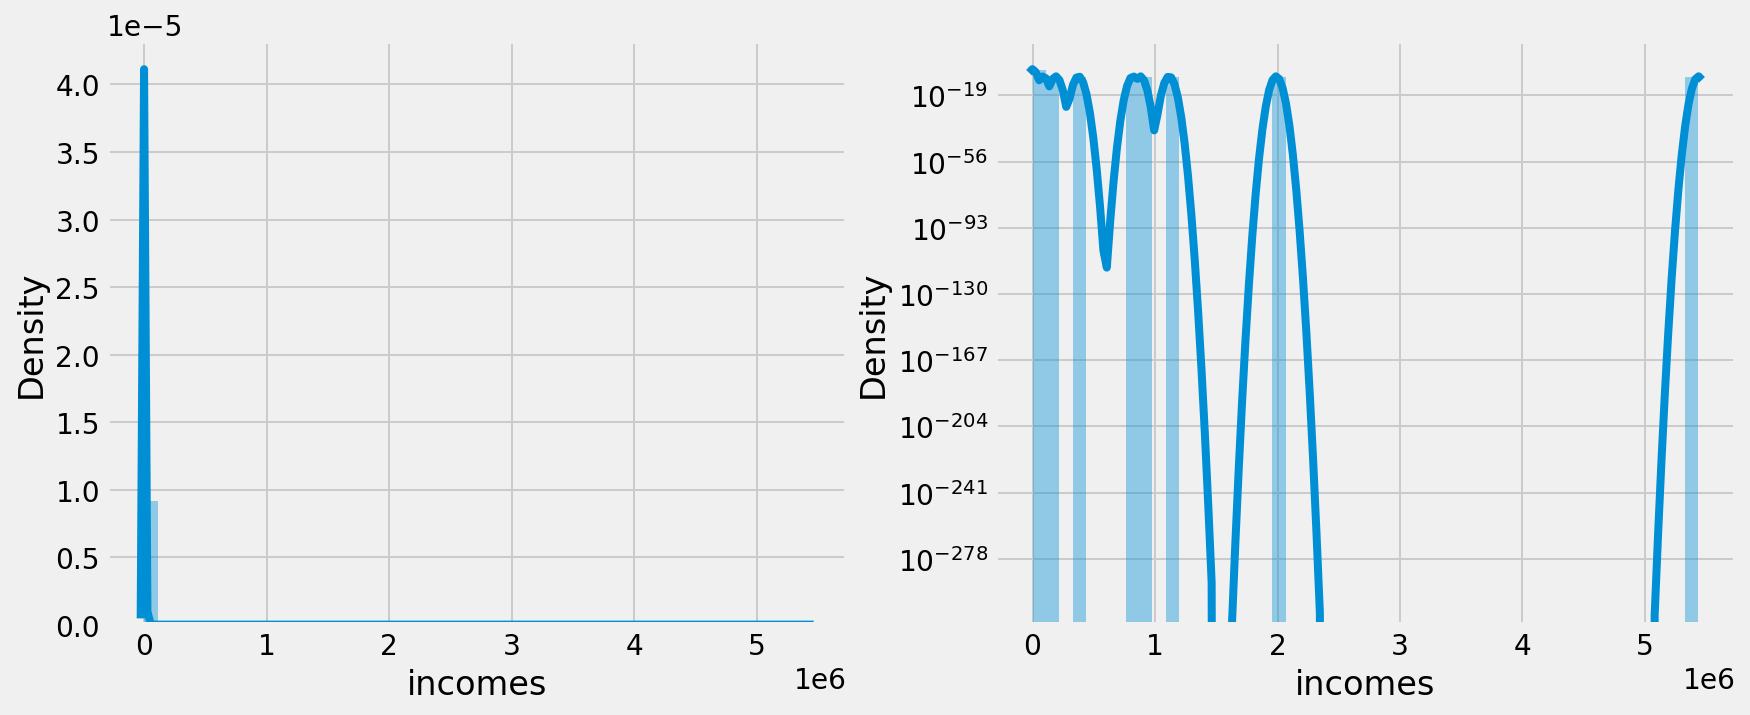

In [48]:
fig, ax = plt.subplots(1,2, figsize=(13,5))
sns.distplot(budgets['incomes'],ax=ax[0])
sns.distplot(budgets['incomes'],ax=ax[1], hist_kws={'log':True})

#### ***기존 meta data 파일이 가지고 있던 정보에 비해 약 5000건 이상의 데이터를 더 확보할 수 있었음***

### 4) genres 장르
- 장르 tag가 여러개로 되어 있는 경우가 대부분
- tag가 없는 경우도 있음
- meta_data는 tmdb api에 기반하기 때문에 movie_len의 tag와는 구분됨
- genres_tmdb tmdb 장르 tag를 지정
- genres_tmdb 장르 tag수 기반으로 장르 복잡성 특성 만듬

### 5) belongs to collection
- 특정 시리즈에 속해 있는 영화에 대한 정보 ex) 007, 해리포터 등등..
- 1개만 속해 있느 시리즈도 꽤 있음(388개)
- collection or not in collenction 으로 분류할지 고민

In [49]:
print('장르 tag 없는 영화 수 :',len([i for i in meta_data['genres'] if len(i)<10 ]))

장르 tag 없는 영화 수 : 2437


In [50]:
def extract_genres(x):
    
    cast = [i['name'] for i in ast.literal_eval(x)] # eval 보다 안전한 방법
    if len(cast) == 0:
        return np.nan
    else :
        for n,i in enumerate(cast):
            if n < 1:
                ss = i
            else :
                ss = ss+'|'+i
        return ss

def number_of_genres(x):
    try :
        return len(x.split('|'))
    except :
        return 0
# 장르 꺼내기
meta_data['genres_tmdb'] = meta_data['genres'].apply(lambda x: extract_genres(x))
# 장르 tag count -> 복잡성
meta_data['genres_tmdb_complexity'] = meta_data['genres_tmdb'].apply(lambda x: number_of_genres(x))
meta_data.head()

,adult,belongs_to_collection,budget,genres,tmdbID,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,title,video,vote_average,vote_count,imdbId,genres_tmdb,genres_tmdb_complexity
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",...,81.0,1,Released,Toy Story,False,7.7,5415.0,0114709,Animation|Comedy|Family,3
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",...,104.0,2,Released,Jumanji,False,6.9,2413.0,0113497,Adventure|Fantasy|Family,3
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,101.0,1,Released,Grumpier Old Men,False,6.5,92.0,0113228,Romance|Comedy,2
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,...,127.0,1,Released,Waiting to Exhale,False,6.1,34.0,0114885,Comedy|Drama|Romance,3
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",...,106.0,1,Released,Father of the Bride Part II,False,5.7,173.0,0113041,Comedy,1


In [51]:
def collections(x):
    if x == '[]':
        return 'none_collection'
    else :
        return ast.literal_eval(x).get('name')

meta_data['collection'] = meta_data['belongs_to_collection'].fillna('[]').apply(lambda x: collections(x))

In [52]:
c = meta_data['collection'].replace('none_collection',np.nan).value_counts() > 2
meta_data['collection'].replace('none_collection',np.nan).value_counts()[c]

The Bowery Boys                                   29
Totò Collection                                   27
James Bond Collection                             26
Zatôichi: The Blind Swordsman                     26
The Carry On Collection                           25
                                                  ..
Witchboard Collection                              3
Design Trilogy                                     3
The Decline of Western Civilization Collection     3
Vampire Karnstein (Hammer series)                  3
Cube Collection                                    3
Name: collection, Length: 627, dtype: int64

### 6) production companies
- 정보가 없는(제작 회사 정보가 없음) 데이터 & 제작 회사 1개 & 1개 이상 데이터의 수가 비슷비슷한 비율로 구성
- 제작사가 여럿이면 첫 번째 제작사 이름을 대표로 사용
- 제작사 count를 남겨둠
- 정보 없는 경우는 결측으로(나중에 encoder, imputer에서 처리)
- ***제작사의 카디널리티가 매우 높기 때문에 10개 이하 작품을 가진 제작사는 etc로 묶음***

### 7) production countries
- 여러 국가에서 제각한 경우도 있음, 1개 이상 국가 데이터 7000건 정도
- 제작 국가 정보가 없는 데이터 6000건 정도
- 대부분 1개 국가에서 제작
- 위와 동일하게 첫 번째 데이터를 대표 국가로 사용
- 제작 국가의 count를 남겨둠
- ***거의 대부분이 영국과 미국이지만 일단 median 값을 기준으로 etc국가 분류***

In [53]:
# 제작사의 수를 count
meta_data['n_production_companies'] = ( meta_data['production_companies'].apply(ast.literal_eval)
                                        .apply(lambda x : len(x) if isinstance(x, list) else np.nan))

In [54]:
def companies(x):
    cast = ast.literal_eval(x)
    if len(cast) < 1:
        return np.nan
    else :
        return cast[0].get('name')
    
# main_production_companies = 첫 번째 제작사를 main으로
meta_data['main_production_companies'] = meta_data['production_companies'].apply(lambda x: companies(x))

In [55]:
min_comp = meta_data['main_production_companies'].value_counts(dropna=False)
min_comp = min_comp[min_comp<11].index.to_list()
min_comp_mapper = {i:'etc' for i in min_comp}
min_comp_mapper

meta_data['main_production_companies'] = ( meta_data['main_production_companies']
                                          .map(min_comp_mapper) # 정의한 mapper로 dic mapping
                                          .fillna(meta_data['main_production_companies']) # ampping에 없는 건 원래 값으로 채움 
                                         )

In [411]:
min_comp_mapper

{'Mars Films': 'etc',
 'Hemdale Film': 'etc',
 'Brandman Productions': 'etc',
 'HBO Documentary Films': 'etc',
 'Studio 4°C': 'etc',
 'Coop 99': 'etc',
 'Česká televize': 'etc',
 'Parts and Labor': 'etc',
 '20th Century Pictures': 'etc',
 'XYZ Films': 'etc',
 'Whitewater Films': 'etc',
 'New Zealand Film Commission': 'etc',
 'Production I.G.': 'etc',
 'Fox Star Studios': 'etc',
 'Finos Film': 'etc',
 'Boll Kino Beteiligungs GmbH & Co. KG': 'etc',
 'American Broadcasting Company (ABC)': 'etc',
 'Solar Productions': 'etc',
 'Pathé Distribution': 'etc',
 'Dark Castle Entertainment': 'etc',
 'Fono Roma': 'etc',
 'Vía Digital': 'etc',
 'WGBH': 'etc',
 'Tokyo Broadcasting System (TBS)': 'etc',
 'Eskwad': 'etc',
 'Paradis Films': 'etc',
 'Instituto Cubano del Arte e Industrias Cinematográficos (ICAIC)': 'etc',
 'Showbox': 'etc',
 'Les Films Corona': 'etc',
 'Walt Disney Television Animation': 'etc',
 'Versus Production': 'etc',
 'Shooting Gallery': 'etc',
 'WDR': 'etc',
 'Epic Productions': '

In [56]:
# 10개 이하 작품을 가진 제작사를 etc로 묶어서 카디널리티 해소
meta_data['main_production_companies'].nunique()

373

In [58]:
# 첫 번째 제작 국가를 main으로, 제작 국가의 수를 count
meta_data['n_production_countries'] = ( meta_data['production_countries'].apply(ast.literal_eval)
                                        .apply(lambda x : len(x) if isinstance(x, list) else np.nan))
meta_data['main_production_countries'] = meta_data['production_countries'].apply(lambda x: companies(x))

In [511]:
meta_data['main_production_countries'].value_counts(dropna=False)

United States of America    18422
NaN                          6274
United Kingdom               3069
France                       2703
Canada                       1498
                            ...  
Liechtenstein                   1
Myanmar                         1
Bermuda                         1
Namibia                         1
Samoa                           1
Name: main_production_countries, Length: 144, dtype: int64

In [59]:
# 제작 국가별 작품수의 median은 8개
meta_data['main_production_countries'].value_counts().reset_index().median().values[0]

8.0

In [60]:
# median을 기준으로 8개 미만 작품을 갖는 국가는 etc로 분류
cutoff = meta_data['main_production_countries'].value_counts().reset_index().median().values[0]
min_countrie = meta_data['main_production_countries'].value_counts(dropna=False)
min_countrie = min_countrie[min_countrie<cutoff].index.to_list()
min_countrie_mapper = {i:'etc' for i in min_countrie}
min_countrie_mapper

meta_data['main_production_countries'] = ( meta_data['main_production_countries']
                                          .map(min_countrie_mapper) # 정의한 mapper로 dic mapping
                                          .fillna(meta_data['main_production_countries']) # ampping에 없는 건 원래 값으로 채움 
                                         )

/Users/gray/Desktop/ai_local/.conda-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

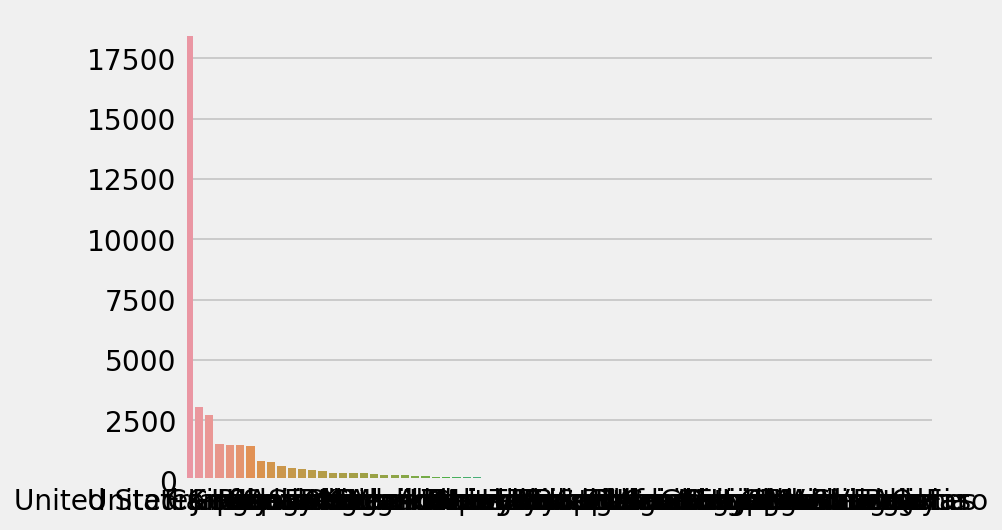

In [513]:
sns.barplot(meta_data['main_production_countries'].value_counts().index, 
            meta_data['main_production_countries'].value_counts().values)

In [61]:
# 제작국가의 종류를 73개로 줄임
cc = meta_data['main_production_countries'].value_counts().reset_index()
cc.shape

(73, 2)

### 8) release date
- 개봉일 정보가 없는 영화 81개 크롤링으로 채워 넣음 그래도 11개는 찾지 못함
- 개봉년도와 개봉 월 정보를 남겨둠,
- 개봉 월 정보가 없는 몇 영화의 경우 1월으로 처리

In [62]:
no_date_id = ( meta_data
              .loc[pd.to_datetime(meta_data['release_date'])
                   .dt.year.isnull(),'imdbId']
              .reset_index() ) # index 정보 가지고 나중에 merge
no_date_id.to_csv('date_info.csv')

In [63]:
# 개봉 년도, 월
meta_data['year'] = pd.to_datetime(meta_data['release_date']).dt.year
meta_data['month'] = pd.to_datetime(meta_data['release_date']).dt.month

In [64]:
# 크롤링 데이터 read
append_date = pd.read_csv([f for f in files if 'date.csv' in str(f)][0])
append_date['year'] = pd.to_datetime(append_date['date']).dt.year
append_date['month'] = pd.to_datetime(append_date['date']).dt.month
append_date['imdbId'] = append_date['imdbId'].str.replace('tt','')
append_date.set_index('index', inplace=True)

In [518]:
append_date.head(3)

,imdbId,date,year,month
index,,,,
711,0114894,9 May 1996,1996.0,5.0
734,0105737,25 September 1992,1992.0,9.0
3460,0210130,May 2000,2000.0,5.0


In [65]:
# meta_data.loc[meta_data['year'].isna(),'year'] = ( meta_data.merge(append_date, 
#                                                                    how='left', 
#                                                                    on='imdbId')['year_y'] )

# 위 nan value를 채우는 merge가 잘 작동하지 않아서
# csv파일 만들 때, 가지고 있던 index 사용해서 값을 넣어줌
for n,i in enumerate(append_date.index):
#     print(i)
    meta_data.loc[append_date.index[n],'year'] = append_date.loc[append_date.index[n],'year']
    meta_data.loc[append_date.index[n],'month'] = append_date.loc[append_date.index[n],'month']

/Users/gray/Desktop/ai_local/.conda-env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='year', ylabel='Density'>

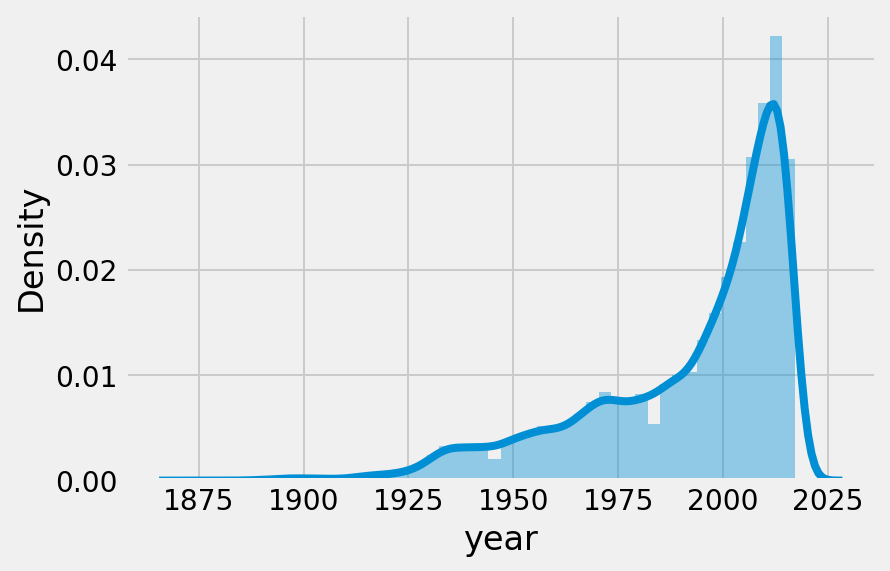

In [66]:
sns.distplot(meta_data['year'])

### 9) status
- 영화가 실제로 개봉하지 않거나, 계획만 있는 경우와 같은 상태를 나타냄
- 큰 도움이 안될 수 있으나, category수가 많지 않아 남겨둠

In [67]:
meta_data['status'].value_counts(dropna=False)

Released           44999
Rumored              228
Post Production       98
NaN                   81
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

## Step 2) Final cleaning & merge budget data
#### 불필요한 컬럼을 제거하고, 크롤링한 예산정보를 merge

In [68]:
def cleaning_meta_data_columns(df):
    
    df = df.copy()
    # 필요없는 컬럼 제거 
    cols = ['adult', 'belongs_to_collection', 'budget', 'genres',
           'production_companies', 'production_countries', 'release_date',
           'revenue', 'video'
           ,'overview'
           ]
    df = df.drop(columns=cols)
    
    return df

meta_data_preprocessed = cleaning_meta_data_columns(meta_data)
print(meta_data_preprocessed.shape, budgets.shape)

budgets['imdbId'] = budgets['imdbId'].str.replace('tt','')
print(budgets.head(2))

# merge incomes
meta_data_preprocessed = ( meta_data_preprocessed
                          .merge(budgets[['imdbId','budget','gross_world','incomes']],how='left', on='imdbId') )
print(meta_data_preprocessed.shape, budgets.shape)

(45443, 20) (45836, 5)
    imdbId      budget    gross_usa  gross_world    incomes
0  0114709  30000000.0  223225679.0  373554033.0  12.451801
1  0113497  65000000.0  100499940.0  262797249.0   4.043035
(45443, 23) (45836, 5)


---


## Step 3) Get rating data from movie len user ratings!
#### ***movie len data에서 user의 rating 정보를 가져옴***

In [69]:
ml = Path('./ml-latest')
ml_files = [g for g in ml.glob('*.csv')]
ml_files

[PosixPath('ml-latest/links.csv'),
 PosixPath('ml-latest/tags.csv'),
 PosixPath('ml-latest/genome-tags.csv'),
 PosixPath('ml-latest/ratings.csv'),
 PosixPath('ml-latest/genome-scores.csv'),
 PosixPath('ml-latest/movies.csv')]

In [70]:
# rating 정보
rating = pd.read_csv([f for f in ml_files if 'ratings' in str(f)][0])
ml_links = pd.read_csv([f for f in ml_files if 'links' in str(f)][0],
                       dtype={'imdbId':'str','tmdbId':'str'})
g = rating.groupby('movieId')['rating'].mean()

# 영화별로 평균한 raing data를 & link에 merge
ml_links = ml_links.merge(g, how='left', on='movieId')

# meta_data에 rating 점수 merge
meta_data_preprocessed = meta_data_preprocessed.merge(ml_links, how='left', on='imdbId')
print('rating 점수 없는 영화:',meta_data_preprocessed['rating'].isna().sum())
print(meta_data_preprocessed.shape)

rating 점수 없는 영화: 615
(45443, 26)


***615개 영화에 rating점수 없음***   
***model만들때 드랍처리***

/Users/gray/Desktop/ai_local/.conda-env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


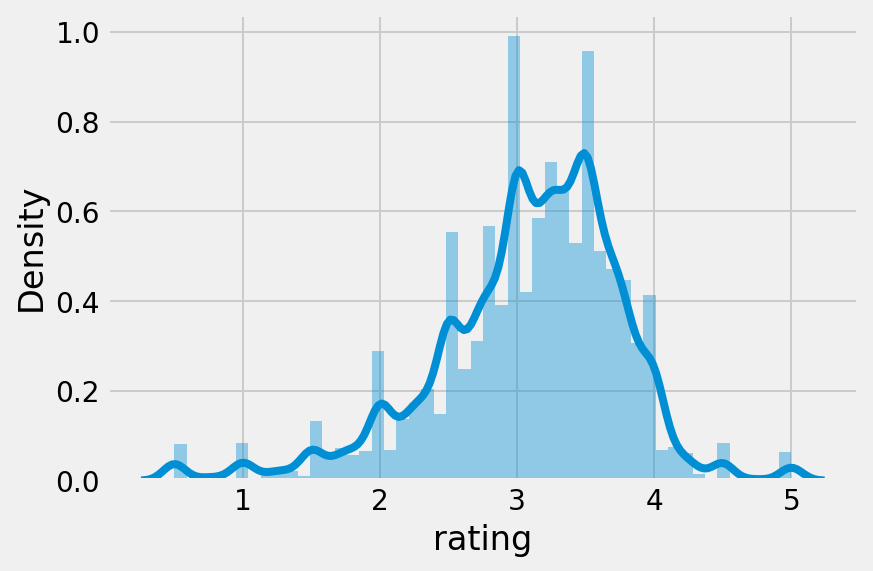

In [71]:
sns.distplot(meta_data_preprocessed['rating']);

In [ ]:
# 간단한 모델 학습은 다른 노트북에서,, 너무 길어서 지저분
# meta_data_preprocessed.to_csv('preprocessed_meta_data.csv')

# 2. Movie credits from tmdb api

## 1. Credits : 배우 & 스텝 
- 여기도 id = tmdbId를 의미함, meta data에서 str로 되어있기 때문에 통일
- 4만개 중 정보 없는 수가 많지는 않음
- 주연배우만 해도 1만8천명의 카디널리티가 있음
- 개별 배우의 수상이력을 사용해서 새로운 지표를 만들 필요가 있음
    - 위키에서 긁어오는 데이터로 데이터를 만들 것
- 스텝의 수를 count해서 영화의 규모를 proxi하는 지표로 삼을 것
- 감독은 따로 빼서 저장(중요한 포인트이기 때문)

In [72]:
credits = pd.read_csv([f for f in files if 'credits' in str(f)][0], dtype={'id':'str'})
credits.rename({'id':'tmdbId'},axis=1, inplace=True)
print(credits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   tmdbId  45476 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB
None


In [73]:
print('cast에서 값이 없는 수 :',len([c for c in credits['cast'] if len(c) < 10 ]))
print('crew 값이 없는 수 :',len([c for c in credits['crew'] if len(c) < 10 ]))

cast에서 값이 없는 수 : 2418
crew 값이 없는 수 : 771


In [75]:
# 여기도 값이 없는 경우 nan이 아닌 []가 들어가 있음
credits['cast'].isnull().sum()

0

#### # 3번째 배우까지 선택, 3명의 성별, 이름을 추출

In [76]:
# json을 그대로 text로 받아온 형태
credits['cast']

0        [{'cast_id': 14, 'character': 'Woody (voice)',...
1        [{'cast_id': 1, 'character': 'Alan Parrish', '...
2        [{'cast_id': 2, 'character': 'Max Goldman', 'c...
3        [{'cast_id': 1, 'character': "Savannah 'Vannah...
4        [{'cast_id': 1, 'character': 'George Banks', '...
                               ...                        
45471    [{'cast_id': 0, 'character': '', 'credit_id': ...
45472    [{'cast_id': 1002, 'character': 'Sister Angela...
45473    [{'cast_id': 6, 'character': 'Emily Shaw', 'cr...
45474    [{'cast_id': 2, 'character': '', 'credit_id': ...
45475                                                   []
Name: cast, Length: 45476, dtype: object

In [77]:
credits['cast_main_5'] = ( credits['cast'].apply(ast.literal_eval)
                            .apply(lambda x: [ x['name'] for x in x[:3]] ) )
credits['cast_main_5_gender'] = ( credits['cast'].apply(ast.literal_eval)
                            .apply(lambda x: [ x['gender'] for x in x[:3]] ) )

In [78]:
# 3명까지 포함하는 list
credits['cast_main_5']

0                      [Tom Hanks, Tim Allen, Don Rickles]
1           [Robin Williams, Jonathan Hyde, Kirsten Dunst]
2               [Walter Matthau, Jack Lemmon, Ann-Margret]
3        [Whitney Houston, Angela Bassett, Loretta Devine]
4               [Steve Martin, Diane Keaton, Martin Short]
                               ...                        
45471          [Leila Hatami, Kourosh Tahami, Elham Korda]
45472           [Angel Aquino, Perry Dizon, Hazel Orencio]
45473         [Erika Eleniak, Adam Baldwin, Julie du Page]
45474    [Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa...
45475                                                   []
Name: cast_main_5, Length: 45476, dtype: object

In [79]:
# 개별 컬럼에 넣어줌
credits[['actor_1_name',
         'actor_2_name',
         'actor_3_name']] = ( credits['cast_main_5']
                             .apply(lambda x: pd.Series(x)) )


credits[['actor_1_gender',
         'actor_2_gender',
         'actor_3_gender']] = ( credits['cast_main_5_gender']
                             .apply(lambda x: pd.Series(x)) )

<ipython-input-79-f974be0c9ae3>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .apply(lambda x: pd.Series(x)) )
<ipython-input-79-f974be0c9ae3>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .apply(lambda x: pd.Series(x)) )


In [231]:
credits.head(3)

,cast,crew,tmdbId,cast_main_5,cast_main_5_gender,actor_1_name,actor_2_name,actor_3_name,actor_1_gender,actor_2_gender,actor_3_gender
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[Tom Hanks, Tim Allen, Don Rickles]","[2, 2, 2]",Tom Hanks,Tim Allen,Don Rickles,2.0,2.0,2.0
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[2, 2, 1]",Robin Williams,Jonathan Hyde,Kirsten Dunst,2.0,2.0,1.0
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[2, 2, 1]",Walter Matthau,Jack Lemmon,Ann-Margret,2.0,2.0,1.0


### 1) 위키api를 활용해서, unique 배우 7만명의 수상(won), 노미네이트(nominate) count! 하려고 했지만 위키 api밴 당했는지 어느시점부터 error만 return됨
### 2) request & beautifulSoup으로 직접 크롤링 수행
- 한계점은 있음, 미국 위키를 기준으로 하기 때문에 헤외 배우들의 정보가 누락된게 많고, wiki text에서 단순히 단어 won, nominate를 count하기 때문에 정확하지는 않음.
- 하지만 어느정도 배우의 수상경력을 반영하는 지표로 삼을 수 있을 것임.


In [436]:
# 유니크 actor들의 이름 get
unique_actors = set([item for sublist in credits['cast_main_5'].to_list() for item in sublist])
unique_actors = dict.fromkeys(unique_actors, 0) 
list(unique_actors)[:5]

['Jacek Fedorowicz',
 'Tôru Masuoka',
 'Tamara Davies',
 'François Bégaudeau',
 'Paola Rinaldi']

In [59]:
# wikipedia api 참고
import wikipediaapi
wiki = wikipediaapi.Wikipedia(language='en',extract_format=wikipediaapi.ExtractFormat.WIKI)
page = wiki.page('Lois Nettleton')
t = page.text
print(t.count('won'), t.count('nominat'))
for name in list(unique_actors)[:20]:
    
    page = wiki.page(name)
    
    if len(page.categories) < 5:
        name = name + ' (actor)'
        page = wiki.page(name)
        unique_actors[name] = (0, 0)
    else :
        t = page.text
        unique_actors[name] = (t.count('won'), t.count('nominat'))


### 3) Crew의 숫자를 단순 count해서 영화의 규모를 반영한 feature 생성
- 크루 정보가 없으면 0

In [80]:
# number of crew 정보가 없으면 nan
credits['n_crew'] = ( 
                        credits['crew'].apply(ast.literal_eval)
                        .apply(lambda x: len(x) if isinstance(x, list) else np.nan) # eval로 반환된 x가 list면 crew의 수
                    )

In [438]:
credits['n_crew']

0        106
1         16
2          4
3         10
4          7
        ... 
45471      9
45472      6
45473      5
45474      2
45475      1
Name: n_crew, Length: 45476, dtype: int64

### 4) 감독 이름은 따로 지정 (후에 감독별 수상이력 추가)

In [439]:
ast.literal_eval(credits['crew'][1])[0]

{'credit_id': '52fe44bfc3a36847f80a7cd1',
 'department': 'Production',
 'gender': 2,
 'id': 511,
 'job': 'Executive Producer',
 'name': 'Larry J. Franco',
 'profile_path': None}

In [81]:
credits['Producer'] = ( 
                    credits['crew'].apply(ast.literal_eval) 
                   .apply(lambda x: x[0]['name'] if len(x)>1 else np.nan) # 반환된 리스트의 element가 없으면, 정보가 없는 경우
                  )

In [535]:
credits['Producer'].value_counts()

Avy Kaufman           124
Ennio Morricone        81
Suzanne Smith          69
Roger Corman           65
Max Steiner            51
                     ... 
Nathan Halpern          1
Daniele Gaglianone      1
Yoram Ben-Ami           1
Fernando Caruso         1
Vidyasagar              1
Name: Producer, Length: 18428, dtype: int64

## 2. Keywords & Tags
- 키워드 & tag는 결측이 너무 많고, 단어 종류가 너무 다양하기 때문에 사용하지 않음

In [121]:
files

[PosixPath('the_movie_dataset/links_small.csv'),
 PosixPath('the_movie_dataset/links.csv'),
 PosixPath('the_movie_dataset/credits.csv'),
 PosixPath('the_movie_dataset/date.csv'),
 PosixPath('the_movie_dataset/movies_metadata.csv'),
 PosixPath('the_movie_dataset/info_budget_1.csv'),
 PosixPath('the_movie_dataset/ratings.csv'),
 PosixPath('the_movie_dataset/info_budget_3.csv'),
 PosixPath('the_movie_dataset/info_budget_2.csv'),
 PosixPath('the_movie_dataset/ratings_small.csv'),
 PosixPath('the_movie_dataset/keywords.csv')]

In [239]:
keywords = pd.read_csv([f for f in files if 'keywords' in str(f)][0], dtype={'id':'str'}) # dtype={'imdbId':'str','tmdbId':'str'}
keywords.rename({'id':'tmdbId'}, axis=1, inplace=True)

In [240]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tmdbId    46419 non-null  object
 1   keywords  46419 non-null  object
dtypes: object(2)
memory usage: 725.4+ KB


In [241]:
print('키워드 없는 수:',len([k for k in keywords['keywords'] if len(k)<10 ]))

키워드 없는 수: 14795


In [242]:
keywords

,tmdbId,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]"
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46416,67758,[]
46417,227506,[]


# 3. Awards_by_Directors data

In [82]:
aw = Path('./awards')
[f for f in aw.glob('*.csv')]
awards = pd.read_csv(aw / '220k_awards_by_directors.csv')
awards.tail()

,director_name,ceremony,year,category,outcome,original_language
225670,Courtney Hoffman,Satellite Awards,2016.0,Satellite Award,Nominated,en
225671,Fanni Metelius,Berlin International Film Festival,2012.0,Crystal Bear,Nominated,sv
225672,Fanni Metelius,Guldbagge Awards,2015.0,Guldbagge,Nominated,sv
225673,Fanni Metelius,Uppsala International Short Film Festival,2012.0,Honorable Mention,Won,sv
225674,Adrian Lai,Asian First Film Festival,2008.0,Swarovski Trophy,Nominated,en


In [83]:
awards['director_name'].value_counts()

Steven Spielberg      331
Joel Coen             330
Martin Scorsese       321
Woody Allen           298
Ethan Coen            294
                     ... 
John Stanley            1
Scott McCullough        1
Heide Pils              1
Shaji Kailas            1
Darren Darnborough      1
Name: director_name, Length: 29503, dtype: int64

In [84]:
# 최대한 일치하는 indexing을 위해 소문자, 이름의 특수문자 제거
awards['name_idx'] = ( awards['director_name'].str.lower()
                      .str.replace(' ','')
                      .str.replace('.','')
                      .str.replace('\'','')
                      .str.replace('\t',''))

<ipython-input-84-cc3f5c7228a6>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  awards['name_idx'] = ( awards['director_name'].str.lower()


In [85]:
# Won은 1점 nominatied는 0.5점
awards['score'] = awards['outcome'].apply(lambda x: 1 if x=='Won' else 0.5)


In [86]:
awards

,director_name,ceremony,year,category,outcome,original_language,name_idx,score
0,Aki Kaurismäki,ACCEC Awards,2004.0,ACCEC Award,Won,fi,akikaurismäki,1.0
1,Aki Kaurismäki,Alliance of Women Film Journalists,2012.0,EDA Award,Nominated,fi,akikaurismäki,0.5
2,Aki Kaurismäki,"Amanda Awards, Norway",1999.0,Amanda,Nominated,fi,akikaurismäki,0.5
3,Aki Kaurismäki,Argentinean Film Critics Association Awards,2013.0,Silver Condor,Nominated,fi,akikaurismäki,0.5
4,Aki Kaurismäki,Argentinean Film Critics Association Awards,2004.0,Silver Condor,Nominated,fi,akikaurismäki,0.5
...,...,...,...,...,...,...,...,...
225670,Courtney Hoffman,Satellite Awards,2016.0,Satellite Award,Nominated,en,courtneyhoffman,0.5
225671,Fanni Metelius,Berlin International Film Festival,2012.0,Crystal Bear,Nominated,sv,fannimetelius,0.5
225672,Fanni Metelius,Guldbagge Awards,2015.0,Guldbagge,Nominated,sv,fannimetelius,0.5
225673,Fanni Metelius,Uppsala International Short Film Festival,2012.0,Honorable Mention,Won,sv,fannimetelius,1.0


In [90]:
# 강독별로 점수를 sum
scores = awards.groupby('name_idx')['score'].sum().reset_index()

In [91]:
scores

,name_idx,score
0,50cent,4.5
1,aagerais-nordentoft,3.5
2,aamirbashir,4.5
3,aamirkhan,40.5
4,aarnetarkas,1.5
...,...,...
29489,โสภณศักดาพิศิษฏ์,1.5
29490,​ljubišasamardžić,11.5
29491,翟俊杰,0.5
29492,백승기,1.0


In [94]:
# top 20 감독
scores.sort_values(by='score', ascending=False)[:20]

,name_idx,score
26228,stevenspielberg,249.5
18174,martinscorsese,226.0
13244,joelcoen,217.5
28812,woodyallen,211.0
5150,clinteastwood,201.0
8151,ethancoen,190.0
22589,quentintarantino,188.0
13740,johnwilliams,186.5
4896,christophernolan,173.5
21741,pedroalmodóvar,172.5


In [96]:
# credits에 merge하기 위한 이름 index 마찬가지고 문자 정리 
credits['name_idx'] = ( credits['Producer'].str.lower()
                      .str.replace(' ','')
                      .str.replace('.','')
                      .str.replace('\'','')
                      .str.replace('\t',''))

<ipython-input-96-8298c6988b12>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  credits['name_idx'] = ( credits['Producer'].str.lower()


In [97]:
# scores를 credits에 merge
credits_ = credits.merge(scores, how='left', on='name_idx')

In [98]:
# 약 절반쯤 감독이 score점수를 받음
credits_['score'].isnull().sum(), credits_.shape

(25170, (45476, 15))

In [99]:
# 컬럼 이름 정리
credits_.rename({'score':'Producer_score','tmdbId':'tmdbID'},axis=1, inplace=True)

In [101]:
credits_.head(3)

,cast,crew,tmdbID,cast_main_5,cast_main_5_gender,actor_1_name,actor_2_name,actor_3_name,actor_1_gender,actor_2_gender,actor_3_gender,n_crew,Producer,name_idx,Producer_score
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[Tom Hanks, Tim Allen, Don Rickles]","[2, 2, 2]",Tom Hanks,Tim Allen,Don Rickles,2.0,2.0,2.0,106,John Lasseter,johnlasseter,50.5
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[2, 2, 1]",Robin Williams,Jonathan Hyde,Kirsten Dunst,2.0,2.0,1.0,16,Larry J. Franco,larryjfranco,NaN
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[2, 2, 1]",Walter Matthau,Jack Lemmon,Ann-Margret,2.0,2.0,1.0,4,Howard Deutch,howarddeutch,1.5


### meta_data에 merge  

In [113]:
meta_data_preprocessed_ = meta_data_preprocessed.merge(credits_[['tmdbID','actor_1_name','actor_2_name'
                                                               ,'actor_3_name','actor_1_gender','actor_2_gender'
                                                               ,'actor_3_gender','n_crew','Producer','Producer_score']], 
                                                             how='left',on='tmdbID')

# 4. WIKI 크롤링 배우 수상 데이터!
- 11시간걸렸다..



In [102]:
path = Path('.')
files = [p for p in path.glob('*.csv')]
files

[PosixPath('date_info.csv'),
 PosixPath('preprocessed_meta_data.csv'),
 PosixPath('preprocessed_meta_data_last.csv'),
 PosixPath('actors.csv'),
 PosixPath('actor_awards_2.csv'),
 PosixPath('actor_awards_3.csv'),
 PosixPath('actor_awards_1.csv')]

In [104]:
files_actor = [f for f in files if 'actor_awards' in str(f)]

ff = (pd.read_csv(f, index_col=None, header=0) for f in files_actor)
actor_awards = pd.concat(ff, axis=0, ignore_index=True)
actor_awards.head()

,name,won,nominat
0,Alfredo Castro,0,0
1,Karina Krawczyk,0,0
2,Kwak Do-won,39,14
3,Anja Jaenicke,0,0
4,Sindi Lacej,1,0


In [114]:
meta_data_preprocessed_

,tmdbID,original_language,original_title,popularity,runtime,spoken_languages,status,title,vote_average,vote_count,...,rating,actor_1_name,actor_2_name,actor_3_name,actor_1_gender,actor_2_gender,actor_3_gender,n_crew,Producer,Producer_score
0,862,en,Toy Story,21.946943,81.0,1,Released,Toy Story,7.7,5415.0,...,3.886649,Tom Hanks,Tim Allen,Don Rickles,2.0,2.0,2.0,106.0,John Lasseter,50.5
1,8844,en,Jumanji,17.015539,104.0,2,Released,Jumanji,6.9,2413.0,...,3.246583,Robin Williams,Jonathan Hyde,Kirsten Dunst,2.0,2.0,1.0,16.0,Larry J. Franco,NaN
2,15602,en,Grumpier Old Men,11.7129,101.0,1,Released,Grumpier Old Men,6.5,92.0,...,3.173981,Walter Matthau,Jack Lemmon,Ann-Margret,2.0,2.0,1.0,4.0,Howard Deutch,1.5
3,31357,en,Waiting to Exhale,3.859495,127.0,1,Released,Waiting to Exhale,6.1,34.0,...,2.874540,Whitney Houston,Angela Bassett,Loretta Devine,1.0,1.0,1.0,10.0,Forest Whitaker,78.5
4,11862,en,Father of the Bride Part II,8.387519,106.0,1,Released,Father of the Bride Part II,5.7,173.0,...,3.077291,Steve Martin,Diane Keaton,Martin Short,2.0,1.0,2.0,7.0,Alan Silvestri,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45514,439050,fa,رگ خواب,0.072051,90.0,1,Released,Subdue,4.0,1.0,...,3.500000,Leila Hatami,Kourosh Tahami,Elham Korda,1.0,0.0,0.0,9.0,Hamid Nematollah,2.0
45515,111109,tl,Siglo ng Pagluluwal,0.178241,360.0,1,Released,Century of Birthing,9.0,3.0,...,4.750000,Angel Aquino,Perry Dizon,Hazel Orencio,1.0,0.0,0.0,6.0,Lav Diaz,51.0
45516,67758,en,Betrayal,0.903007,90.0,1,Released,Betrayal,3.8,6.0,...,1.000000,Erika Eleniak,Adam Baldwin,Julie du Page,1.0,2.0,1.0,5.0,Mark L. Lester,3.0
45517,227506,en,Satana likuyushchiy,0.003503,87.0,0,Released,Satan Triumphant,0.0,0.0,...,3.000000,Iwan Mosschuchin,Nathalie Lissenko,Pavel Pavlov,2.0,1.0,2.0,2.0,Yakov Protazanov,NaN


In [115]:
# actor 3명에 각각 merge해 주어야하기 때문에 순차적으로 left, right on을 사용해서 merge하고 컬럼을 정리
tmp_1 = ( meta_data_preprocessed_
         .merge(actor_awards, left_on='actor_1_name', right_on='name',how='left')
         .rename({'won':'actor_1_won','nominat':'actor_1_nominat'},axis=1).drop('name',axis=1) )
tmp_1 = ( tmp_1
         .merge(actor_awards, left_on='actor_2_name', right_on='name',how='left')
         .rename({'won':'actor_2_won','nominat':'actor_2_nominat'},axis=1).drop('name',axis=1) )
tmp_1 = ( tmp_1
         .merge(actor_awards, left_on='actor_3_name', right_on='name',how='left')
         .rename({'won':'actor_3_won','nominat':'actor_3_nominat'},axis=1).drop('name',axis=1) )
tmp_1

,tmdbID,original_language,original_title,popularity,runtime,spoken_languages,status,title,vote_average,vote_count,...,actor_3_gender,n_crew,Producer,Producer_score,actor_1_won,actor_1_nominat,actor_2_won,actor_2_nominat,actor_3_won,actor_3_nominat
0,862,en,Toy Story,21.946943,81.0,1,Released,Toy Story,7.7,5415.0,...,2.0,106.0,John Lasseter,50.5,52.0,118.0,10.0,10.0,7.0,2.0
1,8844,en,Jumanji,17.015539,104.0,2,Released,Jumanji,6.9,2413.0,...,1.0,16.0,Larry J. Franco,NaN,26.0,56.0,1.0,0.0,27.0,70.0
2,15602,en,Grumpier Old Men,11.7129,101.0,1,Released,Grumpier Old Men,6.5,92.0,...,1.0,4.0,Howard Deutch,1.5,13.0,20.0,25.0,55.0,22.0,57.0
3,31357,en,Waiting to Exhale,3.859495,127.0,1,Released,Waiting to Exhale,6.1,34.0,...,1.0,10.0,Forest Whitaker,78.5,263.0,218.0,20.0,74.0,4.0,16.0
4,11862,en,Father of the Bride Part II,8.387519,106.0,1,Released,Father of the Bride Part II,5.7,173.0,...,2.0,7.0,Alan Silvestri,NaN,22.0,48.0,28.0,69.0,8.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45514,439050,fa,رگ خواب,0.072051,90.0,1,Released,Subdue,4.0,1.0,...,0.0,9.0,Hamid Nematollah,2.0,4.0,19.0,NaN,NaN,NaN,NaN
45515,111109,tl,Siglo ng Pagluluwal,0.178241,360.0,1,Released,Century of Birthing,9.0,3.0,...,0.0,6.0,Lav Diaz,51.0,15.0,18.0,NaN,NaN,0.0,0.0
45516,67758,en,Betrayal,0.903007,90.0,1,Released,Betrayal,3.8,6.0,...,1.0,5.0,Mark L. Lester,3.0,1.0,0.0,2.0,0.0,0.0,0.0
45517,227506,en,Satana likuyushchiy,0.003503,87.0,0,Released,Satan Triumphant,0.0,0.0,...,2.0,2.0,Yakov Protazanov,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [119]:
tmp_1.head().T

,0,1,2,3,4
tmdbID,862,8844,15602,31357,11862
original_language,en,en,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
popularity,21.946943,17.015539,11.7129,3.859495,8.387519
runtime,81.0,104.0,101.0,127.0,106.0
spoken_languages,1,2,1,1,1
status,Released,Released,Released,Released,Released
title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
vote_average,7.7,6.9,6.5,6.1,5.7
vote_count,5415.0,2413.0,92.0,34.0,173.0


In [120]:
tmp_1.to_csv('preprocessed_meta_data_last.csv')